<a href="https://colab.research.google.com/github/EmilisGit/Vaizdu_apdorojimas/blob/main/Vaizdu_apdorojimas_lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import polars as pl
import os
import io
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers

In [2]:
splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet', 'valid': 'data/valid-00000-of-00001.parquet'}
train_ds = pl.read_parquet('hf://datasets/rainerberger/Mri_segmentation/' + splits['train'])
test_ds = pl.read_parquet('hf://datasets/rainerberger/Mri_segmentation/' + splits['test'])
valid_ds = pl.read_parquet('hf://datasets/rainerberger/Mri_segmentation/' + splits['valid'])

In [3]:
train_ds.columns

['image', 'annotation']

In [4]:
type(train_ds['image'][0]['bytes'])

bytes

In [5]:
print("Validation dataset rows: ", len(valid_ds))
print("Validation dataset rows: ", len(train_ds))
print("Validation dataset rows: ", len(test_ds))

Validation dataset rows:  200
Validation dataset rows:  400
Validation dataset rows:  100


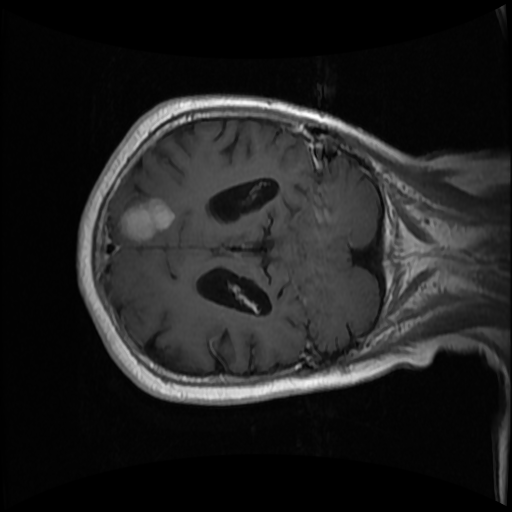

In [6]:
example_img = Image.open(io.BytesIO(train_ds['image'][0]['bytes']))
example_img

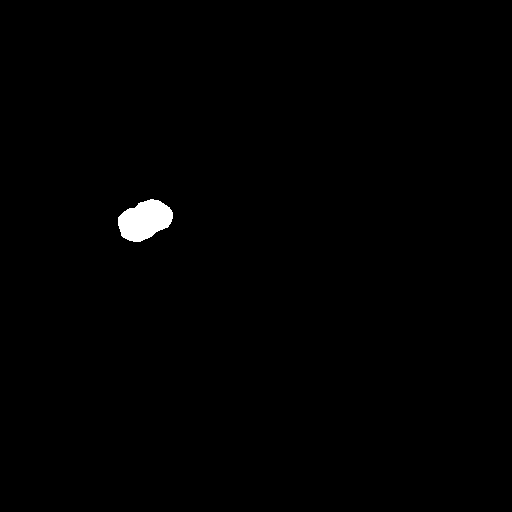

In [7]:
example_img = Image.open(io.BytesIO(train_ds['annotation'][0]['bytes']))
example_img

In [8]:
BATCH_SIZE = 10
IMG_SIZE = (256, 256)

In [9]:
#@title Convert byte arrays to numpy, resize, normalize and convert to tf dataset
def bytes_to_numpy(image_bytes):
    image = Image.open(io.BytesIO(image_bytes))
    image = image.resize(IMG_SIZE)
    return np.array(image)

def to_tf_dataset(dataset, batch_size, buffer_size):
  x = [bytes_to_numpy(entry['bytes']).astype("float32") / 255 for entry in dataset['image']]
  y = [bytes_to_numpy(entry['bytes']).astype("int32") / 255 for entry in dataset['annotation']]

  dataset = tf.data.Dataset.from_tensor_slices((x, y))
  dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
  return dataset.shuffle(buffer_size)

tf_train_ds = to_tf_dataset(train_ds, BATCH_SIZE, 100)
tf_test_ds = to_tf_dataset(test_ds, BATCH_SIZE, 100)
tf_valid_ds = to_tf_dataset(valid_ds, BATCH_SIZE, 100)

## Prepare U-Net Xception-style model

In [15]:
def get_model(img_size):
    inputs = keras.Input(shape=img_size + (1,))  # Grayscale: only 1 channel

    ### [First half: downsampling inputs] ###

    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x

    for filters in [32, 64, 128]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])
        previous_block_activation = x

    ### [Second half: upsampling inputs] ###

    for filters in [128, 64, 32, 16]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])
        previous_block_activation = x

    # Final output layer for binary segmentation
    outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model


In [11]:
model = get_model(IMG_SIZE)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ activation[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 128, 128,  │      1,344 │ activation_1[0][… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ separable_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 128, 128,  │      1,344 │ activation_2[0][… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ separable_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │      1,056 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 64, 64,    │      2,400 │ activation_3[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 64, 64,    │          0 │ batch_normalizat

 Total params: 520,097 (1.98 MB)

 Trainable params: 518,177 (1.98 MB)

 Non-trainable params: 1,920 (7.50 KB)

## Train the model (raining ran 2 times x30 epochs)

In [16]:
from keras.models import load_model

if os.path.exists("mri_segmentation.keras"):
  model = load_model("mri_segmentation.keras")
else:
  model.compile(
      optimizer='sgd',
      loss = "mse",
      metrics=[keras.metrics.BinaryIoU(
          target_class_ids=(0,1),
          threshold=0.3
      )],
  )

callbacks = [
    keras.callbacks.ModelCheckpoint("mri_segmentation.keras", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 30
model.fit(
    tf_train_ds,
    epochs=epochs,
    validation_data=tf_valid_ds,
    callbacks=callbacks,
    verbose=2,
)

Epoch 1/30
80/80 - 15s - 183ms/step - binary_io_u: 0.7598 - loss: 0.0079 - val_binary_io_u: 0.6869 - val_loss: 0.0126
Epoch 2/30
80/80 - 2s - 29ms/step - binary_io_u: 0.7635 - loss: 0.0078 - val_binary_io_u: 0.6937 - val_loss: 0.0120
Epoch 3/30
80/80 - 2s - 28ms/step - binary_io_u: 0.7675 - loss: 0.0076 - val_binary_io_u: 0.6838 - val_loss: 0.0131
Epoch 4/30
80/80 - 3s - 32ms/step - binary_io_u: 0.7705 - loss: 0.0075 - val_binary_io_u: 0.6940 - val_loss: 0.0121
Epoch 5/30
80/80 - 2s - 30ms/step - binary_io_u: 0.7732 - loss: 0.0074 - val_binary_io_u: 0.6962 - val_loss: 0.0121
Epoch 6/30
80/80 - 3s - 33ms/step - binary_io_u: 0.7767 - loss: 0.0072 - val_binary_io_u: 0.7017 - val_loss: 0.0116
Epoch 7/30
80/80 - 2s - 28ms/step - binary_io_u: 0.7797 - loss: 0.0071 - val_binary_io_u: 0.7012 - val_loss: 0.0117
Epoch 8/30
80/80 - 2s - 28ms/step - binary_io_u: 0.7826 - loss: 0.0070 - val_binary_io_u: 0.7021 - val_loss: 0.0117
Epoch 9/30
80/80 - 2s - 30ms/step - binary_io_u: 0.7849 - loss: 0.0069

## Visualize predictions

In [17]:
model = load_model("mri_segmentation.keras")

val_preds = model.predict(tf_valid_ds)

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


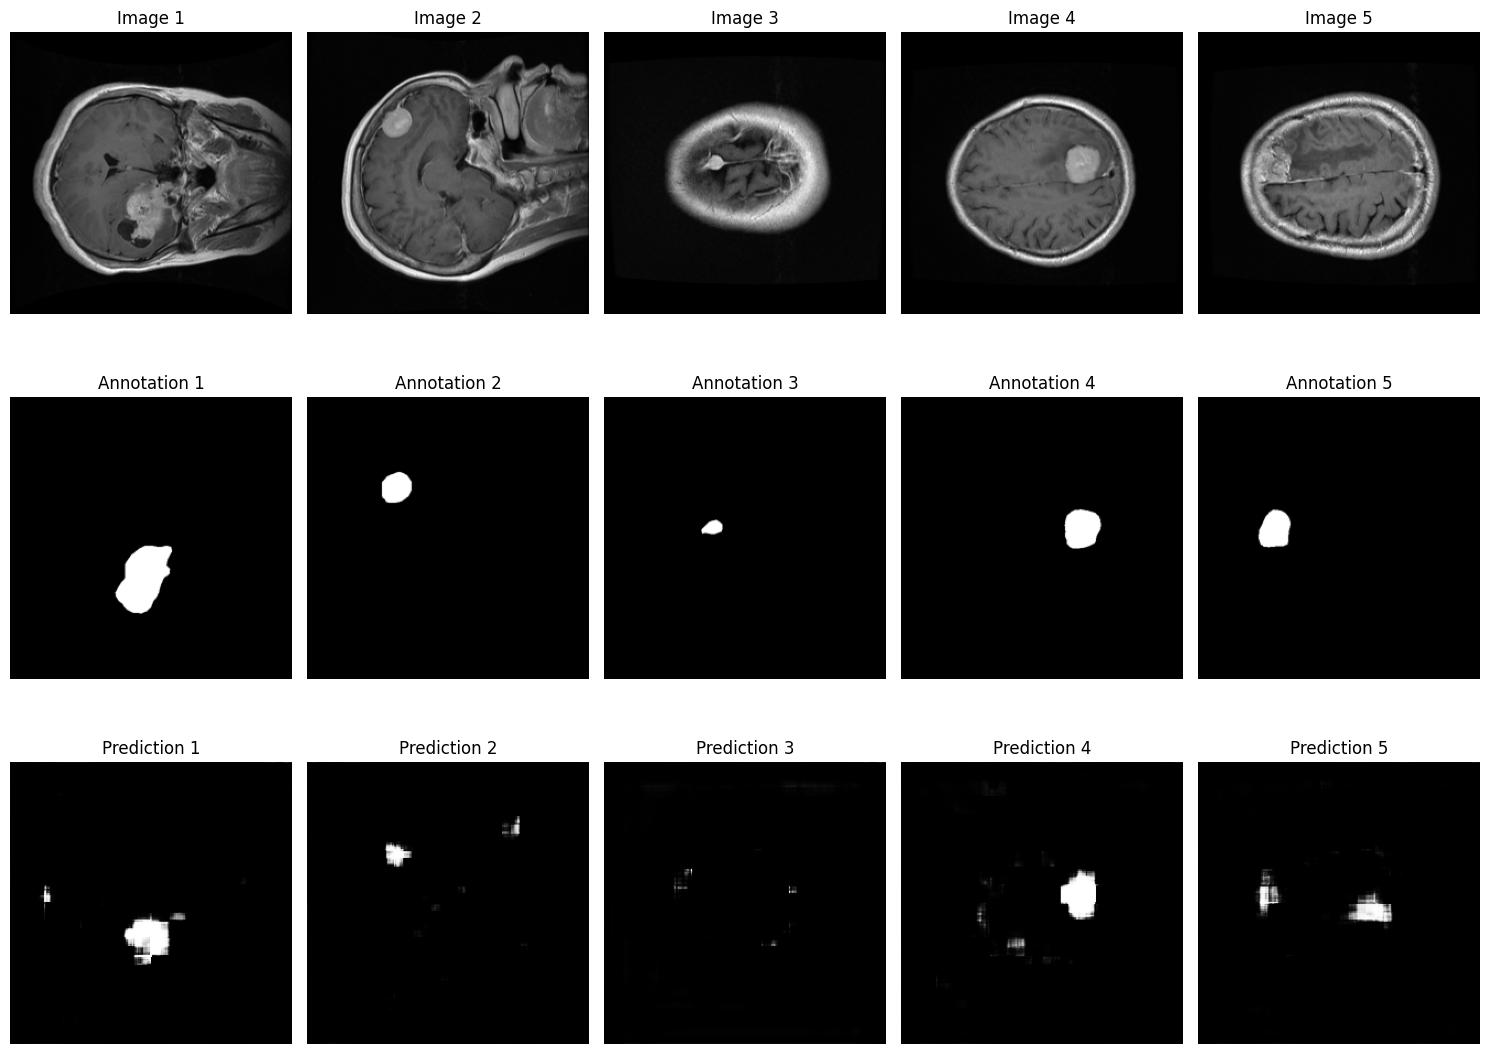

In [18]:
# Take the first 5 batches from the validation dataset
for i, (images, annotations) in enumerate(tf_test_ds.take(1)):
  # Only take the first 5 images and annotations from the batch
  images = images[:5]
  annotations = annotations[:5]

  # Make predictions on the first 5 images
  predictions = model.predict(images)

  # Display the first 5 validation dataset images, annotations, and predictions
  plt.figure(figsize=(15, 15))
  for j in range(5):
      # Original Image
      plt.subplot(4, 5, j + 1)
      plt.imshow(images[j].numpy().squeeze(), cmap='gray')
      plt.title(f"Image {j+1}")
      plt.axis('off')

      # True Annotation
      plt.subplot(4, 5, j + 6)
      plt.imshow(annotations[j].numpy().squeeze(), cmap='gray')
      plt.title(f"Annotation {j+1}")
      plt.axis('off')

      # Predicted Mask
      plt.subplot(4, 5, j + 11)
      plt.imshow(predictions[j].squeeze(), cmap='gray')
      plt.title(f"Prediction {j+1}")
      plt.axis('off')

  plt.tight_layout()
  plt.show()